<a href="https://colab.research.google.com/github/lowrense/PCM---recyclability/blob/main/NN_recycled_materialz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


123/123 - 2s - 16ms/step - loss: 0.4052 - mae: 0.7753 - val_loss: 0.2923 - val_mae: 0.6267
Epoch 2/500
123/123 - 0s - 3ms/step - loss: 0.2772 - mae: 0.5985 - val_loss: 0.2340 - val_mae: 0.5342
Epoch 3/500
123/123 - 0s - 4ms/step - loss: 0.2428 - mae: 0.5424 - val_loss: 0.2169 - val_mae: 0.5013
Epoch 4/500
123/123 - 1s - 5ms/step - loss: 0.2312 - mae: 0.5227 - val_loss: 0.2093 - val_mae: 0.4899
Epoch 5/500
123/123 - 1s - 5ms/step - loss: 0.2248 - mae: 0.5124 - val_loss: 0.2050 - val_mae: 0.4769
Epoch 6/500
123/123 - 1s - 9ms/step - loss: 0.2201 - mae: 0.5046 - val_loss: 0.2020 - val_mae: 0.4719
Epoch 7/500
123/123 - 0s - 3ms/step - loss: 0.2174 - mae: 0.4992 - val_loss: 0.2008 - val_mae: 0.4715
Epoch 8/500
123/123 - 1s - 5ms/step - loss: 0.2153 - mae: 0.4952 - val_loss: 0.1988 - val_mae: 0.4676
Epoch 9/500
123/123 - 0s - 3ms/step - loss: 0.2140 - mae: 0.4924 - val_loss: 0.1982 - val_mae: 0.4664
Epoch 10/500
123/123 - 1s - 5ms/step - loss: 0.2124 - mae: 0.4890 - val_loss: 0.1965 - val_ma

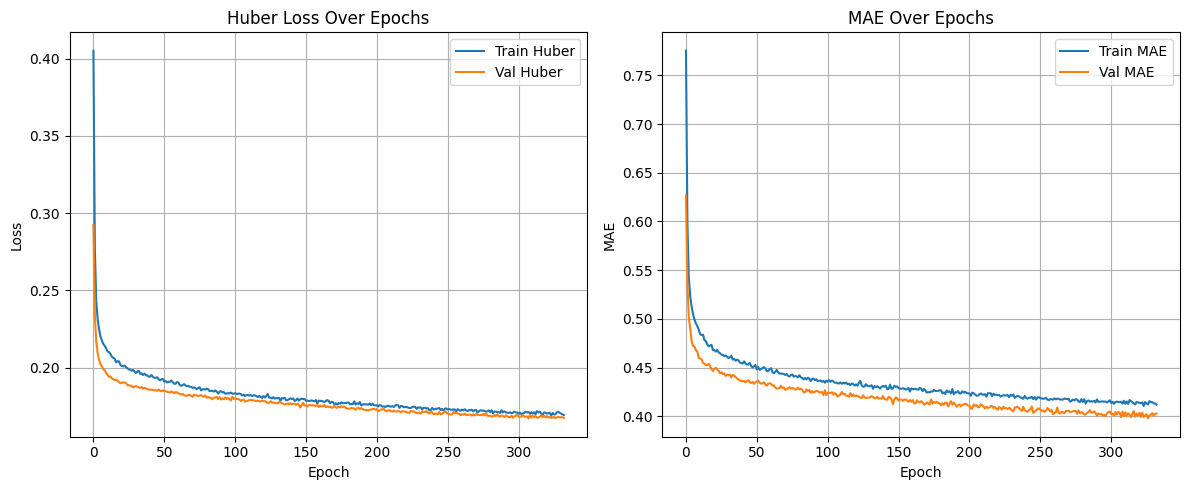

In [ ]:
# 1) Load & preprocess
df = pd.read_excel(
    "buildings_10000_enriched.xlsx",
    na_values=["NA","unspecified","Unspecified"]
)
df = df.loc[:, ~df.columns.str.lower().str.contains("unnamed")]
df = df.dropna(
    subset=[c for c in df.columns if c not in [
        'country','no_floors','occupation','urban_rural',
        'avrg_income','avrg_housing_price'
    ]],
    how='all'
).fillna(0)

feature_cols = [
    'country','no_floors','occupation','urban_rural',
    'avrg_income','avrg_housing_price'
]
target_cols  = [c for c in df.columns if c not in feature_cols]

X = pd.get_dummies(df[feature_cols], drop_first=True).values.astype(np.float32)
y = df[target_cols].astype(float).values

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X_scaled, y_scaled, test_size=0.30, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, random_state=42
)

# 2) Best hyperparameters we found
best_hps = {
    "units_0":      128,
    "l2_0":   1.9974525520146183e-06,
    "dropout_0":      0.0,
    "learning_rate": 0.00032409501212600874
}

# 3) Build the model with a second hidden layer
model = Sequential([
    # first hidden block
    Dense(
        best_hps["units_0"],
        activation='relu',
        kernel_regularizer=l2(best_hps["l2_0"]),
        input_shape=(X_train.shape[1],)
    ),
    Dropout(best_hps["dropout_0"]),

    # second hidden block (new)
    Dense(
        64,              # try 64 units
        activation='relu',
        kernel_regularizer=l2(1e-6)  # small L2; tune as needed
    ),
    Dropout(0.10),      # 10% dropout; tune as needed

    # output layer
    Dense(y_train.shape[1], name='output')
])

# 4) Compile with Huber loss
model.compile(
    optimizer=Adam(learning_rate=best_hps["learning_rate"], clipnorm=1.0),
    loss=Huber(delta=1.0),
    metrics=['mae']
)

# 5) EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True,
    verbose=1
)

# 6) Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)

# 7) Evaluate
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Huber Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# 8) Plot training curves
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'],    label='Train Huber')
plt.plot(history.history['val_loss'],label='Val Huber')
plt.title('Huber Loss Over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['mae'],     label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epoch'); plt.ylabel('MAE')
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error

# 1) Re-compute your arrays (if you haven’t already)
y_true = scaler_y.inverse_transform(y_test)
y_pred = scaler_y.inverse_transform(model.predict(X_test))

# 2) Overall MAE
mae_overall = mean_absolute_error(y_true, y_pred)

# 3) Flatten the true-value array and compute its percentile
flat_true = y_true.flatten()
pct_overall = (flat_true <= mae_overall).mean() * 100

print(f"Overall MAE = {mae_overall:.2f} kg/m², which is the "
      f"{pct_overall:.1f}th percentile of all true values.")

# 4) (Optional) Do the same per-material
maes_per_mat = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
for i, mat in enumerate(target_cols):
    pct_i = (y_true[:,i] <= maes_per_mat[i]).mean() * 100
    print(f"  {mat:10s}  MAE={maes_per_mat[i]:6.2f}  → {pct_i:5.1f}th percentile")


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Overall MAE = 40.13 kg/m², which is the 67.1th percentile of all true values.
  steel       MAE=  7.64  →  24.8th percentile
  wood        MAE= 12.45  →  23.1th percentile
  concrete    MAE=179.19  →  14.0th percentile
  glass       MAE=  0.78  →   6.5th percentile
  plastics    MAE=  0.62  →  45.3th percentile


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


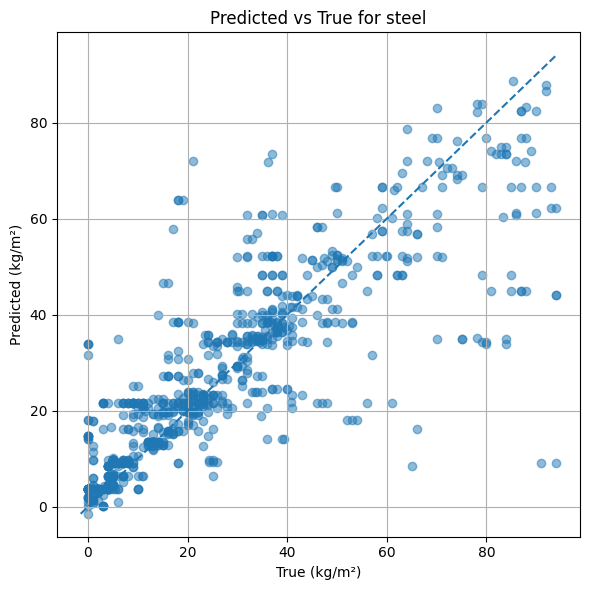

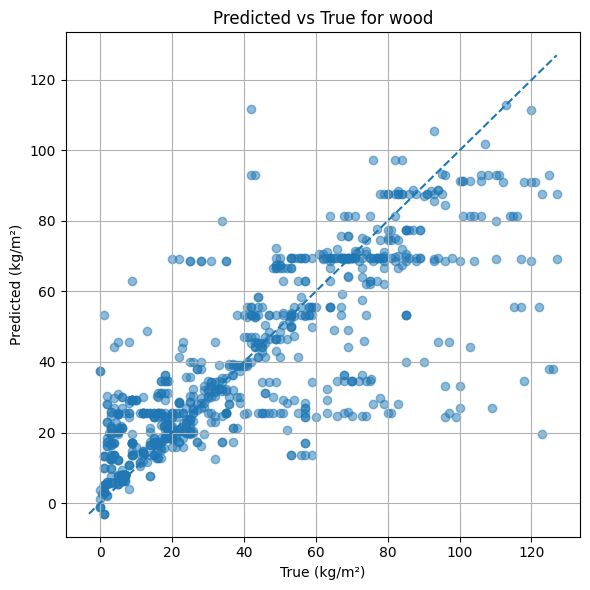

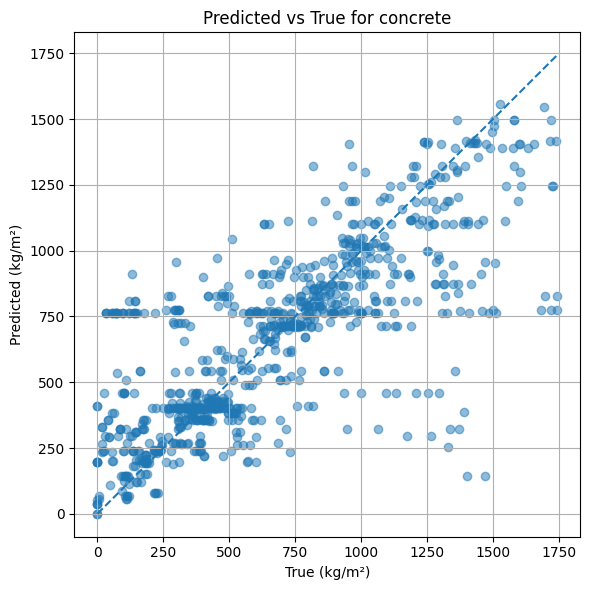

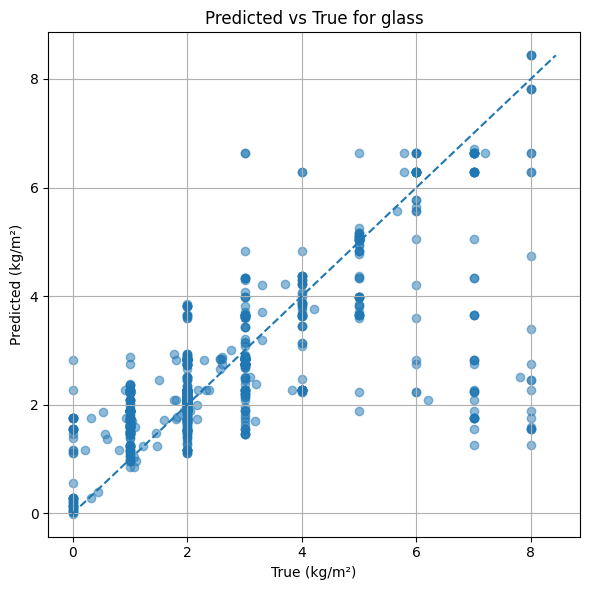

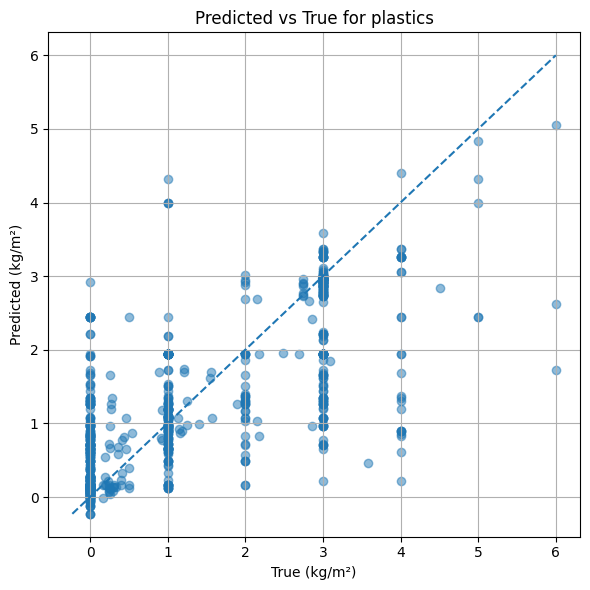

In [ ]:
import matplotlib.pyplot as plt

# 1) Reconstruct true & predicted in original units
y_true = scaler_y.inverse_transform(y_test)
y_pred = scaler_y.inverse_transform(model.predict(X_test))

# 2) For each material, make a scatter + y=x reference line
for i, col in enumerate(target_cols):
    plt.figure(figsize=(6,6))
    plt.scatter(
        y_true[:, i],
        y_pred[:, i],
        alpha=0.5
    )
    # 45° line
    mn = min(y_true[:, i].min(), y_pred[:, i].min())
    mx = max(y_true[:, i].max(), y_pred[:, i].max())
    plt.plot([mn, mx], [mn, mx], linestyle='--')

    plt.title(f"Predicted vs True for {col}")
    plt.xlabel("True (kg/m²)")
    plt.ylabel("Predicted (kg/m²)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

computing recycled materials amounts

In [ ]:
# 1) Your predicted amounts (in kg/m²) for each material
df_pred = pd.DataFrame(
    y_pred,
    columns=target_cols
)

# 2) Standard recycling rates
recycle_rates = {
    'steel':   0.60,
    'wood':    0.70,
    'concrete':0.05,
    'glass':   0.60,
    'plastics':0.20
}

# 3) Compute recycled quantities
df_recycled = df_pred.copy()
for mat, rate in recycle_rates.items():
    if mat in df_recycled:
        df_recycled[mat] = df_recycled[mat] * rate

# 4) (Optional) Total recycled per project
df_recycled['total_recycled'] = df_recycled.sum(axis=1)

# Now df_recycled holds, for each project row:
# – the recycled kg/m² per material
# – the total recycled material density
print(df_recycled.head(),)


       steel       wood   concrete     glass  plastics  total_recycled
0  44.017788  21.939661  74.858620  2.162925  0.145060      143.124054
1  43.214489  13.642917  36.413219  1.358190  0.593060       95.221886
2  11.836382   5.536752  38.757435  1.647849  0.131737       57.910156
3   2.201564  48.561565  20.202021  1.360185  0.033440       72.358772
4  12.337335  14.877481  16.087034  1.022625  0.121721       44.446194


% di riciclato per progetto (comparando i kg/sqm totali di riciclato con i kg/sqm totali di tutti materiali di un progetto)

In [ ]:
# 1) Your predicted amounts (in kg/m²) for each material
df_pred = pd.DataFrame(
    y_pred,
    columns=target_cols
)

# 2) Standard recycling rates
recycle_rates = {
    'steel':    0.60,
    'wood':     0.70,
    'concrete': 0.05,
    'glass':    0.60,
    'plastics': 0.20
}

# 3) Compute recycled quantities
df_recycled = df_pred.copy()
for mat, rate in recycle_rates.items():
    if mat in df_recycled:
        df_recycled[mat] = df_recycled[mat] * rate

# 4) Total predicted & recycled per project
df_pred['total_predicted']   = df_pred.sum(axis=1)
df_recycled['total_recycled'] = df_recycled.sum(axis=1)

# 5) Percent recycled
df_recycled['pct_recycled'] = (
    df_recycled['total_recycled']
    / df_pred['total_predicted']
) * 100

# 6) Combine for ease of view
df_summary = pd.concat([
    df_pred[['total_predicted']],
    df_recycled[['total_recycled','pct_recycled']]
], axis=1)

print(df_summary.head())

   total_predicted  total_recycled  pct_recycled
0      1606.207886      143.124054      8.910681
1       825.007385       95.221886     11.541944
2       806.190735       57.910156      7.183183
3       479.517517       72.358772     15.089912
4       365.869446       44.446194     12.148103
